In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB_1'
grid, lon, lat, tem, sal, ssh, U, V, W, tmask = functions_plot.load_model_output(path, cfg)
utau, vtau = functions_plot.load_model_other(path, cfg)
depth_levels = grid['deptht'][:]

In [26]:
def plot_incoming_speeds(U_vel, V_vel, gridT, depth_ind, time_inds, time_shot, max_vel, bathy_file, utau):
    
    # definitions
    x_point = 160; y_min = 55; y_max = 80; fs = 14.5
    dep_m = round(gridT['deptht'][:][depth_ind],2)

    fig = plt.figure(figsize=(20,12))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,1,2)
    fig.tight_layout()
    
    # find the speed at a depth and time to create pcolor
    x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_shot, 1)
    p = ax1.pcolor(speeds, vmin=0, vmax=max_vel, cmap='Spectral_r')
    viz_tools.plot_land_mask(ax1, bathy_file,'grid', dep_m, None, None, 'wheat')
    timestamp = nc_tools.timestamp(gridT, time_shot).format('MMM DD, HH:mm')
    ax1.set_title('Domain flow speeds on ' + timestamp + ' (' + str(dep_m) + ' m)', fontsize = fs)
    fig.colorbar(p, ax=ax1); ax1.tick_params(labelsize=fs)
    ax1.set_ylabel('y index', fontsize = fs); ax1.set_xlabel('x index', fontsize = fs)
    
    # define and plot the transect
    y_line = np.arange(y_min,y_max)
    x_line = np.ones_like(y_line)*x_point
    ax1.plot(x_line, y_line, linewidth=5, c='k', label='transect'); ax1.legend(loc=1)
    
    # convert all time indices into datetimes and convert these into matplotlib version
    dates = []
    utau_new = np.zeros(len(time_inds))
    for i in np.arange(len(time_inds)):
        dates.append(nc_tools.get_datetimes(grid)[time_inds[i]])
        utau_new[i] = utau[time_inds[i],-1,-1]
    dates = matplotlib.dates.date2num(dates)
    
    date_shot0 = nc_tools.get_datetimes(grid)[time_shot]
    date_shot = matplotlib.dates.date2num(date_shot0)
    
    # plot the wind stress
    ax2.plot_date(dates, utau_new, c='k', lw=3, markersize=8)
    ax2.axvline(date_shot, c = 'dodgerblue', lw=3, label='')
    ax2.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax2.legend(loc=1); ax2.set_ylim([0.02, -0.16]); ax2.tick_params(labelsize=fs)
    ax2.set_title('Wind stress profile', fontsize = fs)
    ax2.set_xlabel('dates', fontsize = fs); ax2.set_ylabel('wind stress [Nm$^{-2}$]', fontsize = fs)

    # crop the velocities for the transect
    U_vel = U_vel[:, :, y_min:y_max, x_point-1:x_point+1]
    V_vel = V_vel[:, :, y_min:y_max, x_point-1:x_point+1]
    
    # get the speeds along the transect at every time index and then store in a matrix
    len_y = len(y_line)-1
    speeds_all = np.zeros([len_y,len(time_inds)])
    for time_ind, m in zip(time_inds, np.arange(len(time_inds))):
        x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_ind, 1)
        for n in zip(np.arange(len_y)):
            speeds_all[n, m] = speeds[n, :]
    
    # define colors for every point along the transect
    cms = np.linspace(0, 1, len_y)
    cs = [ cm.jet(x) for x in cms]
    
    # plot speeds at every point and use plot_date to use matplotlib's datetime 
    for n in np.arange(len_y):
        ax3.plot_date(dates, speeds_all[n, :], color = cs[n], linestyle='-', label = str(y_line[n]))
    ax3.axvline(date_shot, c = 'dodgerblue', lw=3, label='')    
    ax3.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax3.legend(ncol=12, loc=1); ax3.tick_params(labelsize=fs)
    ax3.set_xlabel('dates', fontsize = fs); ax3.set_ylabel('flow speed [ms$^{-1}$]', fontsize = fs)
    ax3.set_title('Speed of the incoming flow different points along the transect', fontsize = fs)
    fig.subplots_adjust(hspace=.2, wspace=.2)
    
    plt.show()
    return fig, dates, speeds_all

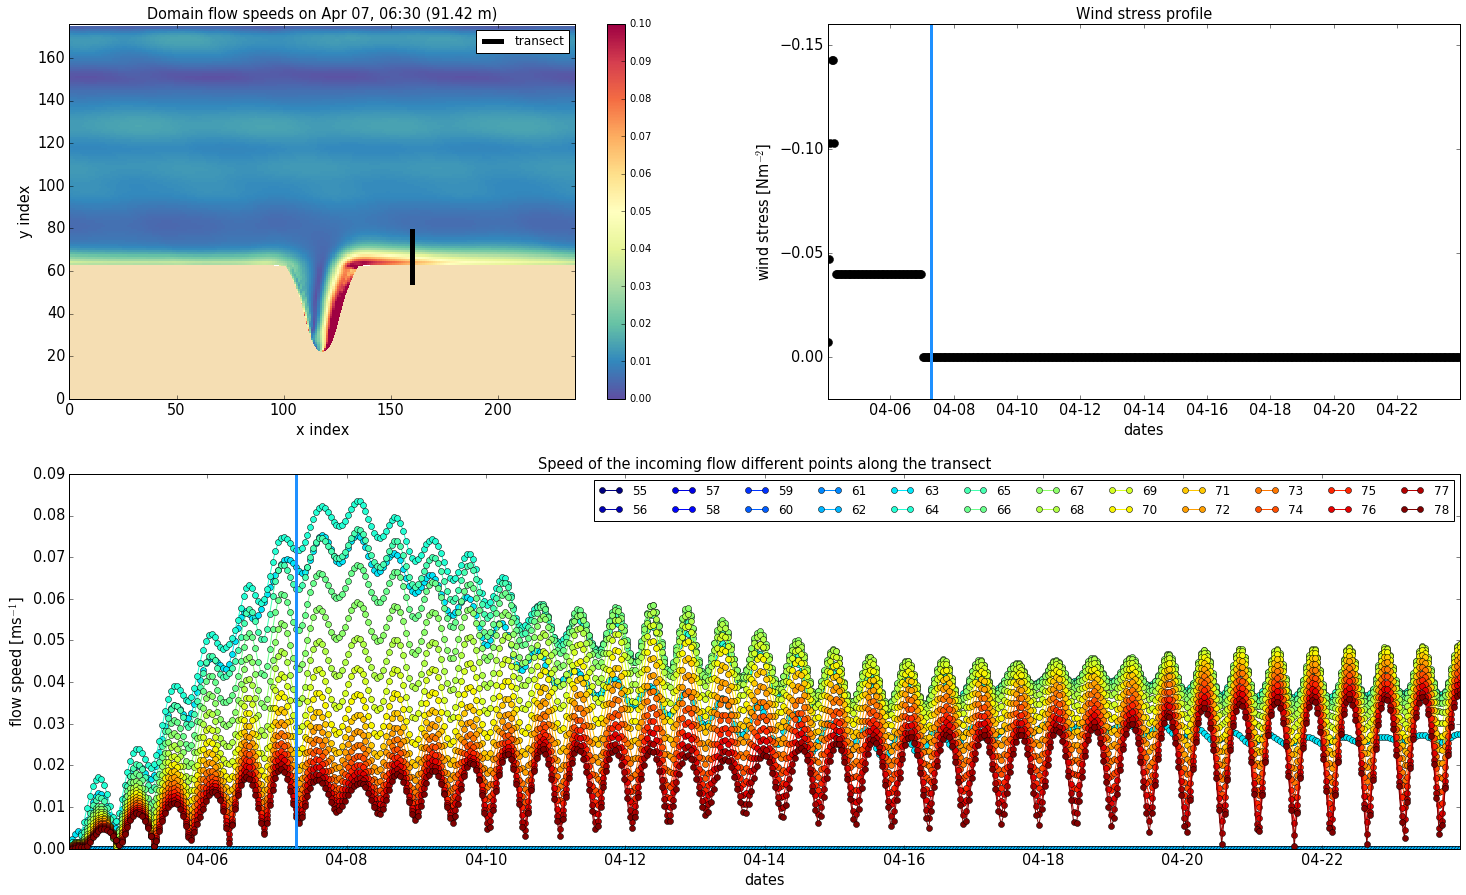

In [27]:
time_shot=3.25*24
time_inds = np.arange(480)
fig, dates, speeds_all = plot_incoming_speeds(U, V, grid, 7, time_inds, time_shot, 0.1, bathy_file, utau)

period [hrs]:  12


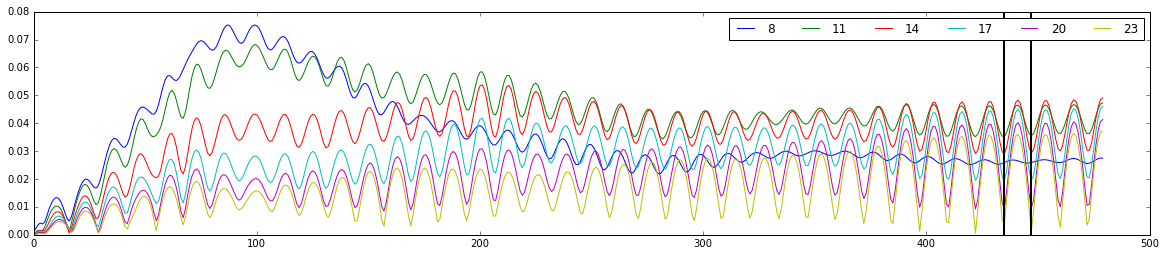

In [101]:
fig, ax = plt.subplots(1,1, figsize=(20,4))
ns = np.arange(8,24,3)
for n in ns:
    ax.plot(speeds_all[n,:], label = str(n))
ax.legend(ncol = 6)
#ax.grid(True, which='both')
#ax.grid(b=True, which='major', color='k', linestyle='-')
#ax.grid(b=True, which='minor', color='k', linestyle='-', alpha=0.5)
#ax.minorticks_on()
#t1, t2 = 346, 359
t1, t2 = 435, 447
ax.axvline(t1, c = 'k', linewidth=2)
ax.axvline(t2, c = 'k', linewidth=2)
print('period [hrs]: ', t2-t1)